# [Trilemma Foundation](https://www.trilemma.foundation/) x [Strategy](https://www.strategy.com/) Stacking Sats Tournament

**Hosted on [Hypertrial.ai](https://www.hypertrial.ai/bitcoin-arena/challenge/bitcoin)**

# Model Development Template

## Python 3.12: Creates Virtual Environment and Imports - Do Not Change → You Will Be Disqualified 🚫
We highly recommend running this cell **only once** as it takes to install all packages.

## Helpers - Do Not Change → You Will Be Disqualified 🚫

In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
#                                     IMPORTS
# ═══════════════════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
import polars as pl
import scipy
import statsmodels.api as sm
import sklearn
import networkx as nx
import pgmpy as pg
import pymc as pm
from prophet import Prophet
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from io import BytesIO
import pyarrow

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ═══════════════════════════════════════════════════════════════════════════════
#                                  CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

# Backtest parameters
BACKTEST_START = '2016-01-01'
BACKTEST_END = '2025-06-01'
INVESTMENT_WINDOW = 12  # months
PURCHASE_FREQ = 'Daily'  # 'Daily', 'Weekly', or 'Monthly'
MIN_WEIGHT = 1e-5

PURCHASE_FREQ_TO_OFFSET = {
    'Daily': '1D',
    'Weekly': '7D',
    'Monthly': '1M',
}

# ═══════════════════════════════════════════════════════════════════════════════
#                                 DATA FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def load_data():
    """Load crypto data directly from GitHub parquet file."""
    url = "https://raw.githubusercontent.com/TrilemmaFoundation/stacking-sats-tournament-mstr-2025/main/data/stacking_sats_data.parquet"
    
    response = requests.get(url)
    response.raise_for_status()
    
    # Read parquet data from bytes
    df = pd.read_parquet(BytesIO(response.content))
    
    # Ensure proper datetime index
    if df.index.name != 'time' and 'time' in df.columns:
        df.set_index('time', inplace=True)
    
    # Clean and sort data
    df.index = pd.to_datetime(df.index).normalize()
    df.index = df.index.tz_localize(None) if df.index.tz is not None else df.index
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    
    return df

# ═══════════════════════════════════════════════════════════════════════════════
#                              COMPUTATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def _make_window_label(window_start: pd.Timestamp, window_end: pd.Timestamp) -> str:
    """Format human-readable rolling window label as 'YYYY-MM-DD → YYYY-MM-DD'."""
    start_str = pd.to_datetime(window_start).strftime("%Y-%m-%d")
    end_str = pd.to_datetime(window_end).strftime("%Y-%m-%d")
    return f"{start_str} → {end_str}"


def compute_cycle_spd(dataframe: pd.DataFrame, strategy_function) -> pd.DataFrame:
    """
    Compute sats-per-dollar (SPD) statistics over rolling windows.
    
    Uses full-history features with no look-ahead bias. Returns DataFrame with
    SPD statistics and percentiles for uniform vs dynamic strategies.
    """
    # Precompute full-history features & restrict to backtest period
    full_feat = construct_features(dataframe).loc[BACKTEST_START:BACKTEST_END]
    
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    
    results = []
    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end = window_start + window_offset
        feat_slice = full_feat.loc[window_start:window_end]
        price_slice = dataframe["PriceUSD_coinmetrics"].loc[window_start:window_end]
        
        if price_slice.empty:
            continue
            
        label = _make_window_label(window_start, window_end)
        inv_price = (1.0 / price_slice) * 1e8  # sats per dollar
        
        # Compute weights and SPD metrics
        weight_slice = strategy_function(feat_slice)
        uniform_spd = inv_price.mean()
        dynamic_spd = (weight_slice * inv_price).sum()
        
        # Percentile calculations
        min_spd = inv_price.min()
        max_spd = inv_price.max()
        span = max_spd - min_spd
        
        uniform_pct = (uniform_spd - min_spd) / span * 100
        dynamic_pct = (dynamic_spd - min_spd) / span * 100
        
        results.append({
            "window": label,
            "min_sats_per_dollar": min_spd,
            "max_sats_per_dollar": max_spd,
            "uniform_sats_per_dollar": uniform_spd,
            "dynamic_sats_per_dollar": dynamic_spd,
            "uniform_percentile": uniform_pct,
            "dynamic_percentile": dynamic_pct,
            "excess_percentile": dynamic_pct - uniform_pct,
        })
    
    return pd.DataFrame(results).set_index("window")


def backtest_dynamic_dca(
    dataframe: pd.DataFrame,
    strategy_function,
    *,
    strategy_label: str = "strategy"
) -> pd.DataFrame:
    """
    Run rolling-window SPD backtest and print aggregated performance metrics.
    
    Includes standard statistics and exponentially-decayed averages with
    recent windows weighted more heavily.
    """
    spd_table = compute_cycle_spd(dataframe, strategy_function)
    dynamic_spd = spd_table["dynamic_sats_per_dollar"]
    dynamic_pct = spd_table["dynamic_percentile"]
    
    # Print standard aggregated metrics
    print(f"\nAggregated Metrics for {strategy_label}:")
    print("Dynamic Sats-per-Dollar:")
    for stat in ("min", "max", "mean", "median"):
        val = getattr(dynamic_spd, stat)()
        print(f"  {stat}: {val:.2f}")
    
    print("\nDynamic SPD Percentiles:")
    for stat in ("min", "max", "mean", "median"):
        val = getattr(dynamic_pct, stat)()
        print(f"  {stat}: {val:.2f}%")
    
    # Exponential decay weighting (recent windows weighted more heavily)
    decay_rate = 0.9
    N = len(dynamic_spd)
    raw_weights = np.array([decay_rate ** (N - 1 - i) for i in range(N)])
    exp_weights = raw_weights / raw_weights.sum()
    
    exp_avg_spd = (dynamic_spd.values * exp_weights).sum()
    exp_avg_pct = (dynamic_pct.values * exp_weights).sum()
    
    print(f"\nExponential-Decay Average SPD: {exp_avg_spd:.2f}")
    print(f"Exponential-Decay Average SPD Percentile: {exp_avg_pct:.2f}%")
    
    return spd_table, exp_avg_pct

# ═══════════════════════════════════════════════════════════════════════════════
#                              VALIDATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def check_strategy_submission_ready(dataframe: pd.DataFrame, strategy_function) -> None:
    """
    Comprehensive validation that strategy function:
    1. Uses no future data (forward-leakage test)
    2. Produces valid weights (≥ MIN_WEIGHT, sum to 1.0)
    3. Outperforms uniform DCA in ≥50% of rolling windows
    """
    passed = True
    
    # Forward-leakage test
    backtest_df = dataframe.loc[BACKTEST_START:BACKTEST_END]
    full_weights = strategy_function(dataframe).reindex(backtest_df.index).fillna(0.0)
    
    step_dates = max(len(backtest_df) // 50, 1)
    probe_dates = backtest_df.index[::step_dates]
    
    for probe in probe_dates:
        masked = dataframe.copy()
        masked.loc[masked.index > probe, :] = np.nan
        
        masked_wt = strategy_function(masked).reindex(full_weights.index).fillna(0.0)
        
        if not np.isclose(masked_wt.loc[probe], full_weights.loc[probe], 
                         rtol=1e-9, atol=1e-12):
            delta = abs(masked_wt.loc[probe] - full_weights.loc[probe])
            print(f"[{probe.date()}] ❌ Forward-leakage detected (Δ={delta:.2e})")
            passed = False
            break
    
    # Weight validation per rolling window
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    
    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end = window_start + window_offset
        label = _make_window_label(window_start, window_end)
        w_slice = strategy_function(dataframe.loc[window_start:window_end])
        
        if (w_slice <= 0).any():
            print(f"[{label}] ❌ Non-positive weights detected.")
            passed = False
        
        if (w_slice < MIN_WEIGHT).any():
            print(f"[{label}] ❌ Weight below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False
        
        total = w_slice.sum()
        if not np.isclose(total, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{label}] ❌ Sum-to-1 check failed: {total:.4f}")
            passed = False
    
    # Performance vs uniform DCA
    spd_table = compute_cycle_spd(dataframe, strategy_function)
    
    underperf_records = []
    for label, row in spd_table.iterrows():
        dp, up = row["dynamic_percentile"], row["uniform_percentile"]
        if dp < up:
            underperf_records.append({
                "Window": label,
                "Dynamic Percentile": dp,
                "Uniform Percentile": up,
                "Delta": dp - up
            })
    
    total = len(spd_table)
    failed = len(underperf_records)
    pass_ratio = (total - failed) / total
    
    if underperf_records:
        df_underperf = pd.DataFrame(underperf_records)
        print("\n⚠️ Windows where strategy underperformed Uniform DCA:")
        display(df_underperf)
    
    print(f"\nSummary: Your strategy underperformed uniform DCA in {failed} out of {total} "
          f"windows ({100 * pass_ratio:.2f}% win rate)")
    
    if pass_ratio >= 0.5:
        print("✅ Strategy meets performance requirement (≥ 50% win rate vs. uniform DCA).")
    else:
        print("❌ Strategy failed performance requirement (< 50% win rate vs. uniform DCA).")
        passed = False
    
    # Final verdict
    if passed:
        print("\n✅ Strategy is ready for submission.")
    else:
        print("\n⚠️ Please address the above issues before submitting.")

# ═══════════════════════════════════════════════════════════════════════════════
#                               PLOTTING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def _get_window_index(timestamp: pd.Timestamp) -> int:
    """Map timestamp to 0-based rolling-window index."""
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    valid_starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step
    )
    idx = valid_starts.get_indexer([timestamp], method='pad')[0]
    return int(idx)


def plot_features(
    df: pd.DataFrame,
    weights: pd.Series | None = None,
    *,
    start_date: str | pd.Timestamp = BACKTEST_START,
    end_date: str | pd.Timestamp = BACKTEST_END,
) -> None:
    """Plot BTC price vs first derived feature within backtest window."""
    df_feat = construct_features(df).loc[start_date:end_date]
    
    if weights is not None:
        weights = weights.loc[df_feat.index]
    
    feature_name = df_feat.columns[1]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"BTC Price and {feature_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    
    ax.plot(df_feat.index, df_feat["PriceUSD_coinmetrics"], label="BTC Price", 
            color="black", alpha=0.7)
    ax.plot(df_feat.index, df_feat[feature_name], label=feature_name, 
            color="orange", alpha=0.7)
    
    signal = df_feat["PriceUSD_coinmetrics"] < df_feat[feature_name]
    ax.fill_between(
        df_feat.index, df_feat["PriceUSD_coinmetrics"], df_feat[feature_name],
        where=signal, color="green", alpha=0.1,
    )
    
    if weights is not None:
        ax.scatter(
            df_feat.index[~signal], df_feat.loc[~signal, "PriceUSD_coinmetrics"],
            marker="o", facecolors="none", edgecolors="blue", label="Uniform",
        )
        ax.scatter(
            df_feat.index[signal], df_feat.loc[signal, "PriceUSD_coinmetrics"],
            marker="o", color="red", label="Dynamic",
        )
    
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_final_weights_by_window(
    dataframe: pd.DataFrame,
    strategy_fn,
    *,
    window_stride: int = 1
):
    """Plot strategy weights for each rolling window (subsampled by window_stride)."""
    window_length = pd.DateOffset(months=INVESTMENT_WINDOW)
    step = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_length,
        freq=step
    )
    
    fig, ax = plt.subplots(figsize=(12, 5))
    cmap = plt.get_cmap("tab10")
    
    for idx, ws in enumerate(starts):
        if idx % window_stride != 0:
            continue
        
        we = ws + window_length
        df_win = dataframe.loc[ws:we]
        w_win = strategy_fn(df_win)
        label = f"{ws.date()} → {we.date()}"
        color = cmap(idx % 10)
        
        ax.plot(w_win.index, w_win.values, label=label, color=color)
        ax.hlines(1.0/len(w_win), w_win.index[0], w_win.index[-1],
                  color=color, linestyle='--', alpha=0.5)
    
    ax.axhline(MIN_WEIGHT, color='black', linestyle='--', 
               label=f"MIN_WEIGHT={MIN_WEIGHT}")
    ax.set_title("Weights by Rolling Window")
    ax.set_xlabel("Date")
    ax.set_ylabel("Weight")
    ax.legend(fontsize='small', ncol=2, loc='upper center')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_rolling_window_weight_sums(dataframe: pd.DataFrame, strategy_fn) -> None:
    """Plot sum of weights for each rolling window (should be ~1.0)."""
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    
    starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step
    )
    
    sums = []
    for ws in starts:
        we = ws + window_offset
        df_window = dataframe.loc[ws:we]
        w = strategy_fn(df_window)
        sums.append(w.sum())
    
    plt.figure(figsize=(12, 5))
    # Plot the actual weight sums (should be close to 1.0)
    plt.plot(starts, sums, marker="o", linestyle="-", color="blue", label="Weight Sums")
    plt.axhline(1.0, color="black", linestyle="--", linewidth=2, label="Target = 1.0")
    
    # Set y-axis to focus around 1.0 to better visualize deviations
    min_sum = min(sums)
    max_sum = max(sums)
    margin = max(0.01, (max_sum - min_sum) * 0.1)  # At least 1% margin
    plt.ylim(min_sum - margin, max_sum + margin)
    
    plt.title("Per-Window Strategy Weight Sums (should be 1.0)")
    plt.xlabel("Window Start Date")
    plt.ylabel("Sum of Weights")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Weight sum statistics:")
    print(f"  Mean: {np.mean(sums):.6f}")
    print(f"  Min:  {min_sum:.6f}")
    print(f"  Max:  {max_sum:.6f}")
    print(f"  Std:  {np.std(sums):.6f}")
    
    plt.tight_layout()
    plt.show()


def plot_spd_comparison(
    spd_results: pd.DataFrame,
    strategy_name: str = "Dynamic",
    *,
    window_stride: int = 1
) -> None:
    """Compare uniform vs dynamic DCA in SPD and percentile space."""
    subs = spd_results.iloc[::window_stride]
    x = np.arange(len(subs))
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale("log")
    
    # Plot SPD lines
    l_max, = ax1.plot(x, subs["max_sats_per_dollar"], "o-", color="green")
    l_dyn, = ax1.plot(x, subs["dynamic_sats_per_dollar"], "o-", color="blue")
    l_uni, = ax1.plot(x, subs["uniform_sats_per_dollar"], "o-", color="orange")
    l_min, = ax1.plot(x, subs["min_sats_per_dollar"], "o-", color="red")
    
    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel("Sats per Dollar (log scale)")
    ax1.set_xlabel("Window")
    ax1.grid(True, linestyle="--", linewidth=0.5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(subs.index, rotation=45, ha="right")
    ax1.legend(
        [l_max, l_dyn, l_uni, l_min],
        ["Max SPD", strategy_name, "Uniform SPD", "Min SPD"],
        loc="upper left",
    )
    
    # Twin axis for percentiles
    ax2 = ax1.twinx()
    bw = 0.4
    ubar = ax2.bar(x - bw/2, subs["uniform_percentile"], width=bw, 
                   alpha=0.3, color='orange')
    dbar = ax2.bar(x + bw/2, subs["dynamic_percentile"], width=bw, 
                   alpha=0.3, color='blue')
    ax2.set_ylabel("SPD Percentile (%)")
    ax2.set_ylim(0, 100)
    ax2.legend([ubar, dbar], ["Uniform %", f"{strategy_name} %"], 
               loc="upper right")
    
    plt.tight_layout()
    plt.show()

## Model Development → Enter Your Strategy Here ✅ 

In [5]:
def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct technical indicators used for the strategy.
    Uses only past data for calculations to avoid look-ahead bias.
    """
    df = df.copy()
    df = df[['PriceUSD_coinmetrics']]
    past_price = df['PriceUSD_coinmetrics'].shift(1)
    df['ma200'] = past_price.rolling(window=200, min_periods=1).mean()
    df['std200'] = past_price.rolling(window=200, min_periods=1).std()
    return df

def compute_weights(df_window: pd.DataFrame) -> pd.Series:
    """
    Given a 12-month slice, compute portfolio weights that sum to 1.
    Whenever a day’s weight is ‘boosted’, redistribute the excess uniformly
    over the last half of the window (i.e. the final ~6 months).
    """
    # 1. Build feature DataFrame and index info
    features = construct_features(df_window)
    dates = features.index
    total_days = len(features)

    # 2. Prepare output Series
    weights = pd.Series(index=dates, dtype=float)

    # 3. Strategy parameters
    #    PURCHASE_FREQ is one of 'Daily', 'Weekly', or 'Monthly'
    # half of the window in rows = half of total_days
    rebalance_window = max(total_days // 2, 1)
    boost_alpha      = 1.25

    # 4. Initialize equal weights
    base_weight  = 1.0 / total_days
    temp_weights = np.full(total_days, base_weight)

    # 5. Extract numpy arrays for speed
    price_array  = features["PriceUSD_coinmetrics"].values
    ma200_array  = features["ma200"].values
    std200_array = features["std200"].values

    # 6. Loop through each day
    for day_idx in range(total_days):
        price = price_array[day_idx]
        ma200 = ma200_array[day_idx]
        std200 = std200_array[day_idx]

        # skip if no valid signal
        if pd.isna(ma200) or pd.isna(std200) or std200 == 0 or price >= ma200:
            continue

        # compute how far below MA200
        z_score = (ma200 - price) / std200

        # boost this day’s weight
        boosted_weight = temp_weights[day_idx] * (1 + boost_alpha * z_score)
        excess = boosted_weight - temp_weights[day_idx]

        # redistribute excess over the last half of the window
        start_redistribution = max(total_days - rebalance_window, day_idx + 1)
        redistribution_indices = np.arange(start_redistribution, total_days)
        if redistribution_indices.size == 0:
            continue  # nothing to drain from

        per_day_reduction = excess / redistribution_indices.size

        # apply only if no one falls below MIN_WEIGHT
        if np.all(temp_weights[redistribution_indices] - per_day_reduction >= MIN_WEIGHT):
            temp_weights[day_idx] = boosted_weight
            temp_weights[redistribution_indices] -= per_day_reduction
        # else: skip this boost but continue looping

    # 7. Assign back into a pandas Series and return
    weights.loc[dates] = temp_weights
    return weights

## Runner - Do Not Change → You Will Be Disqualified 🚫

Starting Bitcoin DCA Strategy Analysis...
Loading data...
Data loaded: 3440 records from 2016-01-01 to 2025-06-01

1. Plotting features...


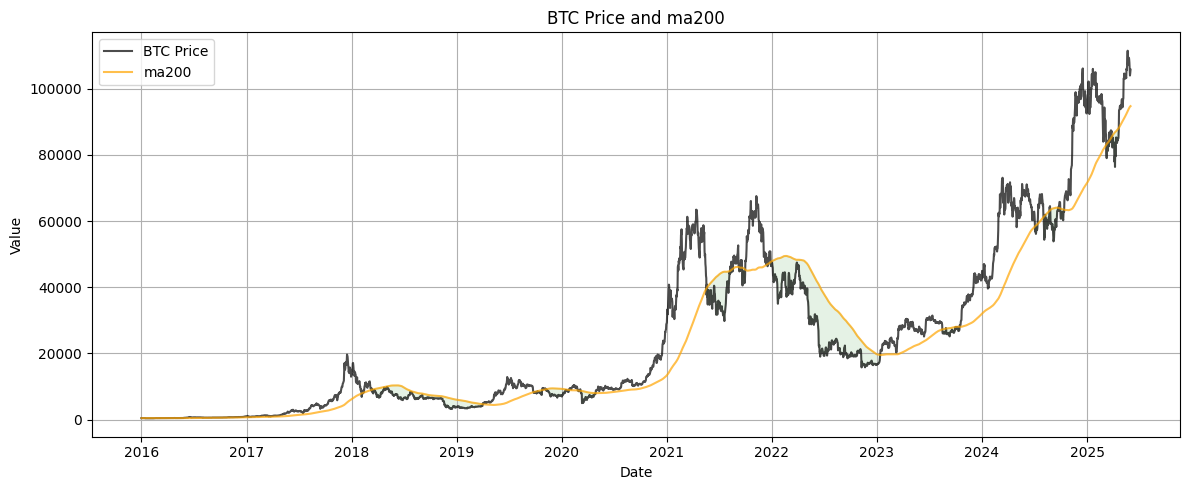


2. Plotting final weights by window...


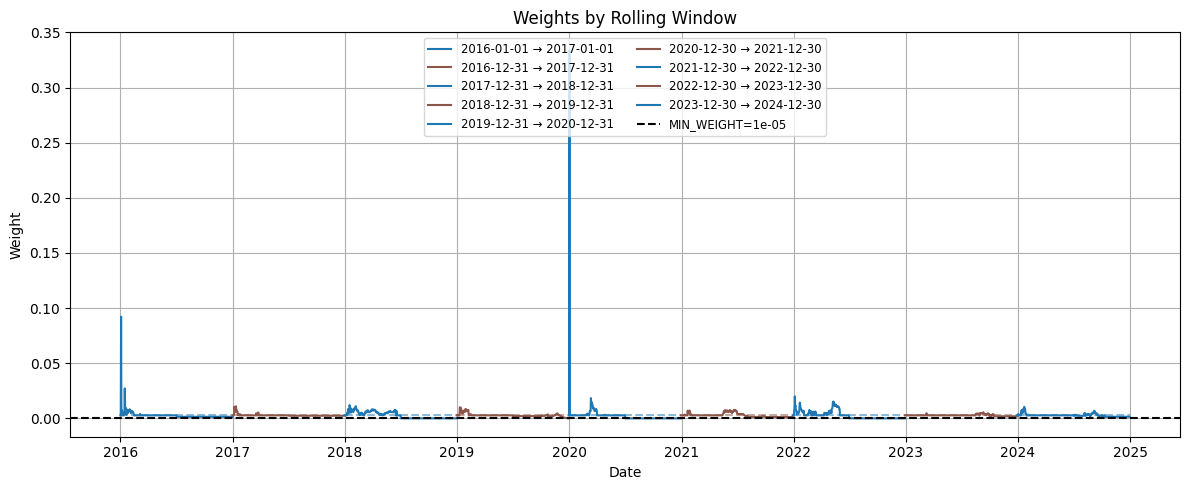


3. Checking rolling window weight sums...
Weight sum statistics:
  Mean: 1.000000
  Min:  1.000000
  Max:  1.000000
  Std:  0.000000


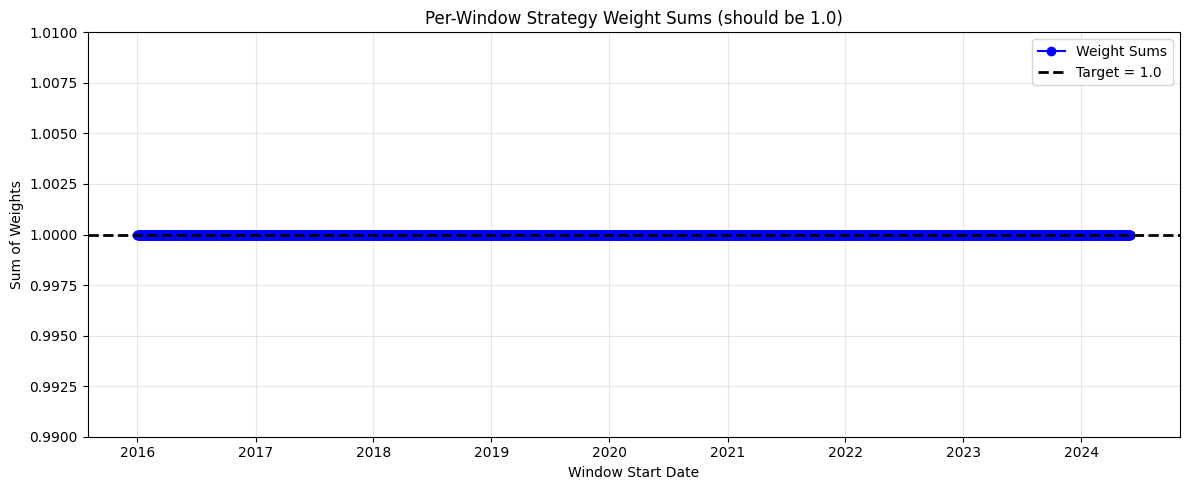


4. Running SPD backtest...

Aggregated Metrics for 200-Day MA DCA:
Dynamic Sats-per-Dollar:
  min: 1515.73
  max: 210356.08
  mean: 23105.17
  median: 8222.09

Dynamic SPD Percentiles:
  min: 9.79%
  max: 87.22%
  mean: 43.92%
  median: 44.29%

Exponential-Decay Average SPD: 1546.28
Exponential-Decay Average SPD Percentile: 67.17%

5. Plotting SPD comparison...


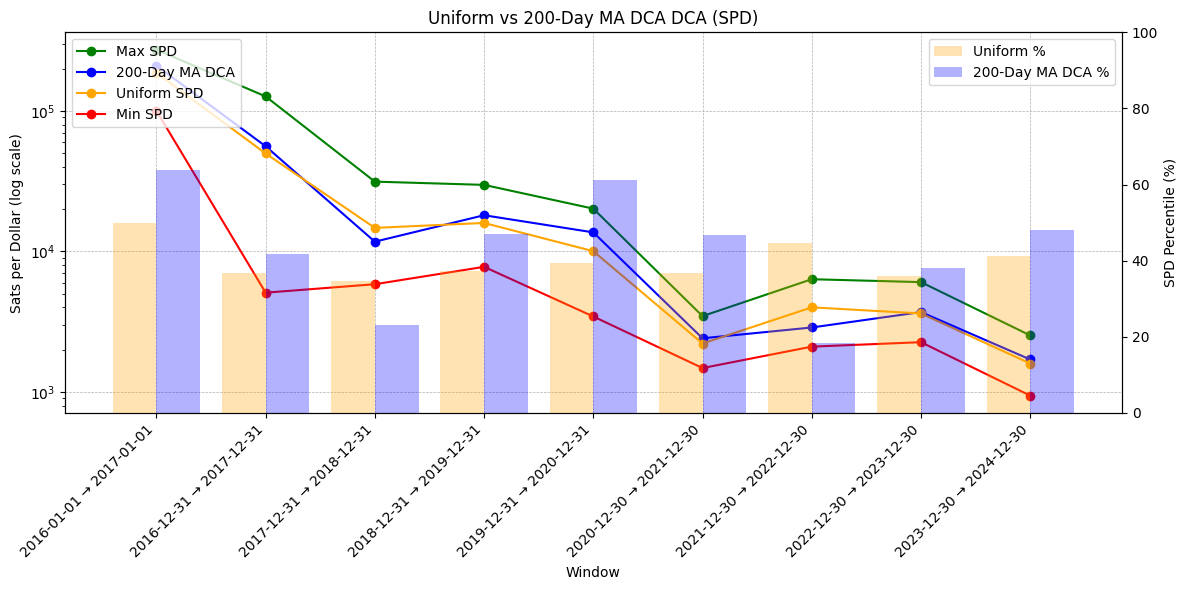


6. Running strategy validation checks...

⚠️ Windows where strategy underperformed Uniform DCA:


,Window,Dynamic Percentile,Uniform Percentile,Delta
0,2016-09-21 → 2017-09-21,43.832610,43.832610,-1.421085e-14
1,2016-09-27 → 2017-09-27,43.011274,43.011274,-1.421085e-14
2,2016-10-19 → 2017-10-19,40.207867,40.207867,-7.105427e-15
3,2016-10-20 → 2017-10-20,40.195303,40.195303,-7.105427e-15
4,2017-07-15 → 2018-07-15,22.317148,22.523968,-2.068205e-01
...,...,...,...,...
668,2022-05-04 → 2023-05-04,52.494032,54.537543,-2.043511e+00
669,2022-05-05 → 2023-05-05,48.923801,51.867349,-2.943549e+00
670,2022-05-06 → 2023-05-06,49.274681,51.452267,-2.177586e+00
671,2022-05-07 → 2023-05-07,50.156180,50.932445,-7.762656e-01



Summary: Your strategy underperformed uniform DCA in 673 out of 3075 windows (78.11% win rate)
✅ Strategy meets performance requirement (≥ 50% win rate vs. uniform DCA).

✅ Strategy is ready for submission.

7. Computing final score...

Final Model Score (50/50 weighting): 72.55%


In [7]:
print("Starting Bitcoin DCA Strategy Analysis...")

# Load and prepare data
print("Loading data...")
btc_df = load_data()
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END]
print(f"Data loaded: {len(btc_df)} records from {BACKTEST_START} to {BACKTEST_END}")

# 1) Feature plot (no weights)
print("\n1. Plotting features...")
plot_features(btc_df)

# 2) Final weights curves—computed per window
print("\n2. Plotting final weights by window...")
plot_final_weights_by_window(
    btc_df,
    compute_weights,
    window_stride=365
)

# 3) Per-window weight-sum check
print("\n3. Checking rolling window weight sums...")
plot_rolling_window_weight_sums(
    btc_df,
    compute_weights
)

# 4) Rolling-window SPD backtest
print("\n4. Running SPD backtest...")
df_spd, exp_decay_percentile = backtest_dynamic_dca(
    btc_df,
    compute_weights,
    strategy_label="200-Day MA DCA"
)

# 5) SPD comparison (subsampled by window_stride)
print("\n5. Plotting SPD comparison...")
plot_spd_comparison(
    df_spd,
    strategy_name="200-Day MA DCA",
    window_stride=365
)

# 6) Sanity checks (each window inside)
print("\n6. Running strategy validation checks...")
check_strategy_submission_ready(btc_df, compute_weights)

# win-rate = % of windows where dynamic beats uniform
win_rate = (df_spd["dynamic_percentile"] > df_spd["uniform_percentile"]).mean() * 100

# 7) Final scoring
print("\n7. Computing final score...")

score = 0.5 * win_rate + 0.5 * exp_decay_percentile
print(f"\nFinal Model Score (50/50 weighting): {score:.2f}%")